<a href="https://colab.research.google.com/github/Jarvis-Geun/DeepLearning-Wiki/blob/main/XAI/SHAP_HTO/MLP_deepshap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network model with SHAP

`-` Reference
- [Using SHAP Values to Explain How Your Machine Learning Model Works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
- [SHAP Values.ipynb](https://github.com/vinyluis/Articles/blob/main/Boruta%20SHAP/SHAP%20Values.ipynb)
- [SHAP latest documentation](https://shap-lrjball.readthedocs.io/en/latest/examples.html#tree-explainer-examples)

## 1. Import

In [24]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [25]:
plt.style.use('default')

## 2. Load dataset

In [26]:
file_names = glob("/home/geun/shap/data_shap/3rd validation HTO_modif_Missing data delete_For AI.xlsx")
# read xlsx format using pandas
# read only first index of the dataset
df = pd.read_excel(file_names[0], engine="openpyxl")

In [27]:
file_names

['/home/geun/shap/data_shap/3rd validation HTO_modif_Missing data delete_For AI.xlsx']

In [28]:
df.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI,Outcome
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30,1
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.25,11.19,9.14,2.05,0,62,149,51,22.97,1
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,-0.83,8.04,5.65,2.39,0,53,148,68,31.04,1
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01,1
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-3.84,11.09,6.51,4.58,0,52,155,83,34.55,1


### Define X

In [29]:
X = df.iloc[:, :-1]
X.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,∆LDFA,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-0.683333,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.856667,-2.25,11.19,9.14,2.05,0,62,149,51,22.97
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,0.666667,-0.83,8.04,5.65,2.39,0,53,148,68,31.04
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-2.373333,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-2.143333,-3.84,11.09,6.51,4.58,0,52,155,83,34.55


### Define y label

In [30]:
y = df.iloc[:, -1]
y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: Outcome, dtype: int64

In [31]:
X.shape, y.shape

((327, 24), (327,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((261, 24), (66, 24), (261,), (66,))

## 3. Deep Neural Network (DNN)

In [33]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [35]:
class BinaryClassification(torch.nn.Module):
  def __init__(self, input_dimension):
    super().__init__()
    self.linear = torch.nn.Linear(input_dimension, 1)

  def forward(self, input_dimension):
      return self.linear(input_dimension)

In [36]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(33,20),
            nn.LeakyReLU(),
            nn.Linear(20,15),
            nn.LeakyReLU(),
            nn.Linear(15,2)
        )
    def forward(self, x) :
        x = self.fc(x)
        return x

In this epoch 50/3000, Training loss: 0.6358, Test loss: 0.6623
In this epoch 100/3000, Training loss: 0.6043, Test loss: 0.6576
In this epoch 150/3000, Training loss: 0.5838, Test loss: 0.6566
In this epoch 200/3000, Training loss: 0.5701, Test loss: 0.6569
In this epoch 250/3000, Training loss: 0.5608, Test loss: 0.6581
In this epoch 300/3000, Training loss: 0.5544, Test loss: 0.6598
In this epoch 350/3000, Training loss: 0.5500, Test loss: 0.6617
In this epoch 400/3000, Training loss: 0.5468, Test loss: 0.6635
In this epoch 450/3000, Training loss: 0.5446, Test loss: 0.6651
In this epoch 500/3000, Training loss: 0.5429, Test loss: 0.6666
In this epoch 550/3000, Training loss: 0.5416, Test loss: 0.6679
In this epoch 600/3000, Training loss: 0.5406, Test loss: 0.6689
In this epoch 650/3000, Training loss: 0.5399, Test loss: 0.6699
In this epoch 700/3000, Training loss: 0.5393, Test loss: 0.6707
In this epoch 750/3000, Training loss: 0.5388, Test loss: 0.6714
In this epoch 800/3000, Tr

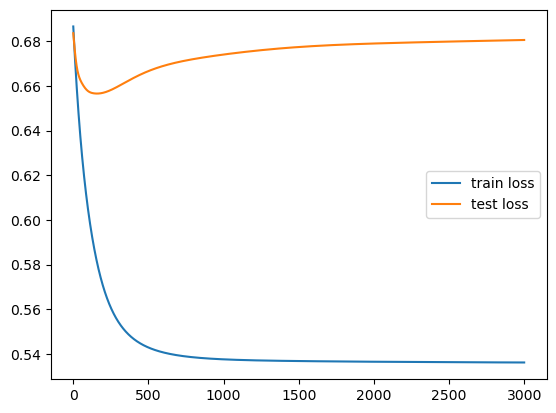

0.735632183908046
0.696969696969697


In [37]:
_, input_dimension = X_train.shape

# model = torch.nn.Linear(input_dimension, 1)
model = BinaryClassification(input_dimension)
# model = Net()

"""train the model"""

def configure_loss_function(): 
  return torch.nn.BCEWithLogitsLoss()

def configure_optimizer(model):
  return torch.optim.Adam(model.parameters())

def full_gd(model, criterion, optimizer, X_train, y_train, n_epochs=3000):
  train_losses = np.zeros(n_epochs)
  test_losses = np.zeros(n_epochs)

  for it in range(n_epochs): 
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
      print(f'In this epoch {it+1}/{n_epochs}, Training loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

  return train_losses, test_losses

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).reshape(-1, 1)
y_test = torch.from_numpy(y_test.astype(np.float32)).reshape(-1, 1)

criterion = configure_loss_function()
optimizer = configure_optimizer(model)
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train)

plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

"""evaluate model"""

with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.numpy() > 0)

  train_acc = np.mean(y_train.numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.numpy() > 0)
  
  test_acc = np.mean(y_test.numpy() == p_test)

print(train_acc)
print(test_acc)

### 3.1 Evaluate the model

## 4. SHAP

In [54]:
import shap

### Bar plot

In [ ]:
shap_values.shape

In [ ]:
shap.plots.bar(shap_values[0])

### Summary plot: beeswarm

In [ ]:
shap.plots.beeswarm(shap_values)

### Summary plot: violin

In [ ]:
shap.summary_plot(shap_values, plot_type="violin")

### Local bar plot: single observation

In [ ]:
shap.plots.bar(shap_values[0])

### Waterfall plot

In [ ]:
shap.plots.waterfall(shap_values[0])

### Force plot

In [ ]:
shap_values[0]

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])